# Test animation of ntwk response

Build mock ntwk response.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csc_matrix
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import aux

V_REST = -0.07
V_TH = -0.04

N_PC = 5000
N_INH = 500

Z_PC = 1
L_PC = 0.1

P_PC_INH = 0.002  # somewhat sparse
P_INH_PC = 0.00004  # super sparse
P_INH_INH = 0.001  # medium sparse

W_A_PC_PC = 0.01
W_A_INH_PC = 0.02
W_G_PC_INH = 0.01
W_G_INH_INH = 0.01

FR_INH = 10

DT = 0.0005
DUR_SMLN = 1
DUR_SEQ = 0.2
TS_SEQ = [0.1, 0.4, 0.7]
T_LEADUP = 0.05

BOUNDS_X = (-1, 1)
BOUNDS_Y = (-0.25, 0.25)

SAVE_PATH = 'anim/cache/test_rsp.npy'


def set_font_size(ax, font_size, legend_font_size=None):
    """Set font_size of all axis text objects to specified value."""

    texts = [ax.title, ax.xaxis.label, ax.yaxis.label] + \
        ax.get_xticklabels() + ax.get_yticklabels()

    for text in texts:
        text.set_fontsize(font_size)

    if ax.get_legend():
        if not legend_font_size:
            legend_font_size = font_size
        for text in ax.get_legend().get_texts():
            text.set_fontsize(legend_font_size)


class NtwkResponse(object):
    
    def __init__(self, v_rest, v_th, ts, vs, spks, pfcs, cell_types, ws_rcr):
        
        self.v_rest = v_rest
        self.v_th = v_th
        self.ts = ts
        self.vs = vs
        self.spks = spks
        self.pfcs = pfcs
        self.cell_types = cell_types
        self.ws_rcr = ws_rcr

In [2]:
def cxns_local(pfcs, z_pc, l_pc):
    
    # get number of cells
    n = pfcs.shape[1]
    
    # build distance matrix
    dx = np.tile(pfcs[0][None, :], (n, 1)) - np.tile(pfcs[0][:, None], (1, n))
    dy = np.tile(pfcs[1][None, :], (n, 1)) - np.tile(pfcs[1][:, None], (1, n))
    d = np.sqrt(dx**2 + dy**2)
    
    # build cxn probability matrix
    p = z_pc * np.exp(-d / l_pc)
    
    # set nans and diagonal to zero
    p[np.eye(n, dtype=bool)] = 0
    p[np.isnan(p)] = 0
    
    # build cxn matrix
    return np.random.rand(n, n) < p


def raster(ax, ts, spks, order=None, **scatter_kwargs):
    """
    Make a raster plot of spiking activity.
    """
    if not len(ts) == len(spks):
        raise Exception('Arg "ts" must be same length as arg "spks".')

    if order is not None:
        spks = spks[:, order]
    
    # get all (spk time, nrn) pair for each spike
    spk_tps, spk_nrns = spks.nonzero()
    spk_ts = ts[spk_tps]
    
    scatter_kwargs = deepcopy(scatter_kwargs)
    
    if 'marker' not in scatter_kwargs:
        scatter_kwargs['marker'] = '|'
    if 'c' not in scatter_kwargs:
        scatter_kwargs['c'] = 'k'
    if 'lw' not in scatter_kwargs:
        scatter_kwargs['lw'] = .3
    if 's' not in scatter_kwargs:
        scatter_kwargs['s'] = 10
        
    ax.scatter(spk_ts, spk_nrns, **scatter_kwargs)
    
    ax.set_xlim(ts[0], ts[-1])
    ax.set_xlabel('t (s)')
    ax.set_ylabel('Neuron')
    
    return ax

Set up ntwk.

In [3]:
n = N_PC + N_INH

cell_types = np.concatenate([np.repeat('PC', N_PC), np.repeat('INH', N_INH)])

pc_slice = np.s_[:N_PC]
inh_slice = np.s_[-N_INH:]

pfcs_x_pc = np.linspace(*BOUNDS_X, N_PC)
pfcs_y_pc = np.random.uniform(*BOUNDS_Y, N_PC)

pfcs_pc = np.array([pfcs_x_pc, pfcs_y_pc])
pfcs = np.concatenate([pfcs_pc, np.nan * np.zeros((2, N_INH))], axis=1)

# AMPA
w_a = np.zeros((n, n), dtype=np.float16)

# to PC from PC
w_a[pc_slice, pc_slice] = W_A_PC_PC * cxns_local(pfcs_pc, Z_PC, L_PC)
# to INH from PC
w_a[inh_slice, pc_slice] = W_A_INH_PC * np.random.binomial(1, P_INH_PC, (N_INH, N_PC))

# GABA
w_g = np.zeros((n, n), dtype=np.float16)

# to PC from INH
w_g[pc_slice, inh_slice] = W_G_PC_INH * np.random.binomial(1, P_PC_INH, (N_PC, N_INH))
# to INH from INH
w_g[inh_slice, inh_slice] = W_G_INH_INH * np.random.binomial(1, P_INH_INH, (N_INH, N_INH))

ws_rcr = {'AMPA': csc_matrix(w_a), 'GABA': csc_matrix(w_g)}

Assign mock dynamics.

In [4]:
ts = np.arange(0, DUR_SMLN, DT)
v_leadup = np.linspace(V_REST, V_TH, int(T_LEADUP/DT))

vs = V_REST * np.ones((len(ts), n), dtype=np.float16)
spks = np.zeros((len(ts), n), dtype=bool)

# PCs
for t_seq in TS_SEQ[::-1]:
    for pc in range(N_PC):
        
        # get spk time
        t_spk = (DUR_SEQ/N_PC) * pc + t_seq
        t_idx = int(round(t_spk / DT))
        
        # add spk
        spks[t_idx, pc] = True
        
        # add voltage leadup
        if t_idx >= len(v_leadup):
            vs[t_idx - len(v_leadup):t_idx, pc] = v_leadup
        else:
            vs[:t_idx, pc] = v_leadup[-t_idx:]
            
# INHs
spks[:, -N_INH:] = np.random.binomial(1, FR_INH * DT, (len(ts), N_INH)).astype(bool)

for t_idx, inh in zip(*spks[:, -N_INH:].nonzero()):
    
    # add voltage leadup
    if t_idx >= len(v_leadup):
        vs[t_idx - len(v_leadup):t_idx, N_PC + inh] = v_leadup
    elif t_idx != 0:
        vs[:t_idx, N_PC + inh] = v_leadup[-t_idx:]

# save response
rsp = NtwkResponse(
    v_rest=V_REST, v_th=V_TH, ts=ts, vs=vs, spks=spks, pfcs=pfcs, cell_types=cell_types, ws_rcr=ws_rcr)
aux.save(SAVE_PATH, rsp)

'anim/cache/test_rsp.npy'

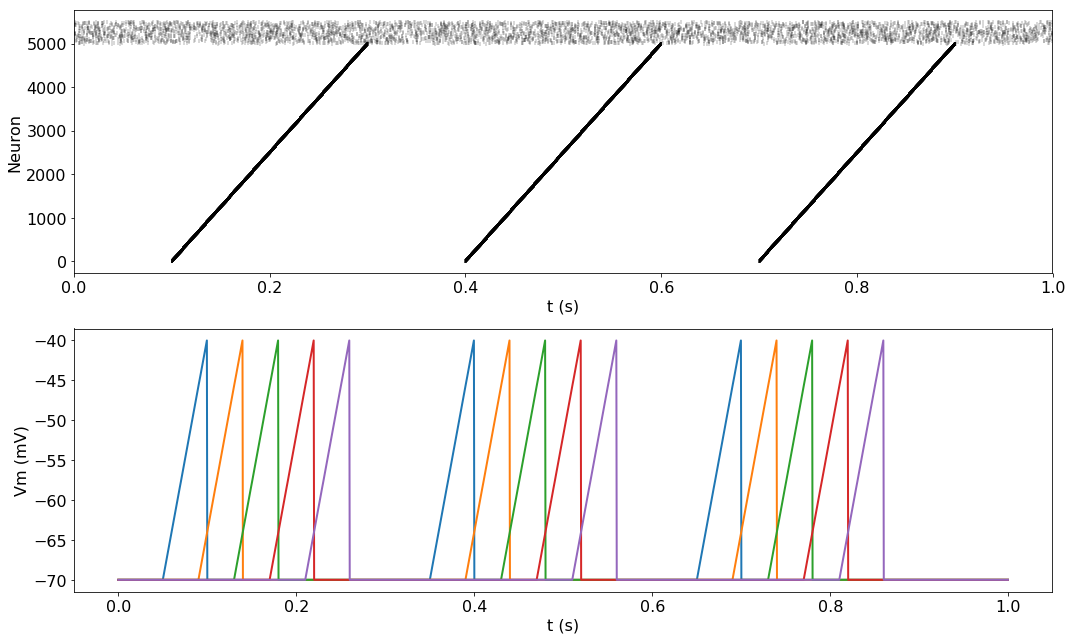

In [5]:
# show raster plot and example voltages
fig, axs = plt.subplots(2, 1, figsize=(15, 9), tight_layout=True)

raster(axs[0], ts, spks)

axs[1].plot(ts, 1000 * vs[:, [0, 1000, 2000, 3000, 4000]], lw=2)
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('Vm (mV)')

for ax in axs:
    set_font_size(ax, 16)

# Build frames of mock network response

In [2]:
from anim import build_frames

rsp = aux.load(SAVE_PATH)

# assign neuron positions
## PC positions are just place field centers
positions = rsp.pfcs.copy()
## INH positions are uniform and random
positions[0, -N_INH:] = np.random.uniform(-0.5, 0.5, N_INH)
positions[1, -N_INH:] = np.random.uniform(-0.875, -0.375, N_INH)

box = (-1.1, 1.1, -.975, 0.35)

frames = build_frames.ntwk(
    frame_prfx='anim/cache/test_frames/frame',
    rsp=SAVE_PATH,
    
    t_start=0.05,
    t_end=0.9,
    positions=positions,
    box=box,
    fig_w=20,
    
    resting_size=50,
    spk_size=500,
    amp=1,
    non_spk_colors={'PC': 'k', 'INH': 'b'},
    spk_color='r',
    
    cxn_colors={('INH', 'PC', 'AMPA'): 'k', ('INH', 'INH', 'GABA'): 'b'},
    cxn_lws={('INH', 'PC', 'AMPA'): 1, ('INH', 'INH', 'GABA'): 1},
    cxn_z_orders={('INH', 'PC', 'AMPA'): -1, ('INH', 'INH', 'GABA'): -2},
    
    x_ticks=(-1.1, 0, 1.1),
    y_ticks=(-0.625, -0.25, 0.25),
    x_tick_labels=(-1.1, 0, 1.1),
    y_tick_labels=('INH', -0.25, 0.25),
    
    x_label='PFC_x (m)',
    y_label='PFC_y (m)',
    title='Ntwk Response',
    font_size=16,
    
    fps=500,
    frames_per_spk=5,
    show_timestamp=True,
    
    verbose=True,
    report_every=5)



Loading activity file "anim/cache/test_rsp.npy"...
Loaded.

Downsampling data from 2000.0 to 500 fps...
Downsampled.

Drawing cxns...
Drawn.

Generating and saving 425 frames spanning times 0.050750 to 0.898750 s...
20 frames completed after 5.169 s...
39 frames completed after 10.309 s...
56 frames completed after 15.346 s...
72 frames completed after 20.351 s...
88 frames completed after 25.515 s...
104 frames completed after 30.782 s...
119 frames completed after 36.008 s...
136 frames completed after 41.213 s...
155 frames completed after 46.487 s...
174 frames completed after 51.586 s...
193 frames completed after 56.830 s...
211 frames completed after 61.908 s...
228 frames completed after 67.016 s...
247 frames completed after 72.228 s...
265 frames completed after 77.288 s...
282 frames completed after 82.647 s...
301 frames completed after 87.860 s...
319 frames completed after 92.897 s...
333 frames completed after 97.951 s...
350 frames completed after 103.045 s...
366 fra

In [3]:
from anim import create_mp4

create_mp4(
    frames,
    save_file='anim/cache/test_mov',
    playback_fps=30)

'anim/cache/test_mov.mp4'